<a href="https://colab.research.google.com/github/Gasca78/Modelo_Regresion_para_Precio_Viviendas/blob/main/Prediccion_Precios_de_Viviendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Portafolio: Predicción de Precios de Viviendas con PyTorch

**Oswaldo Gasca**

**Objetivo:** Este proyecto implementa un modelo de regresión para predecir el precio de viviendas. El flujo de trabajo abarca el preprocesamiento de un dataset masivo, manejo de outliers, feature engineering y el entrenamiento de una Red Neuronal Densa (DNN) con PyTorch.

In [3]:
# ===================================================================
# 1. Carga de Librerías y Definición de Funciones
# ===================================================================

# Importación de librerías esenciales
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ----------------- Funciones Auxiliares -----------------

def matriz_corr(data, ancho, alto):
    """Genera y muestra un mapa de calor de la matriz de correlación."""
    matriz_corr = data.corr()
    plt.figure(figsize=(ancho,alto))
    sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Mapa de calor de Correlación del dataset")
    plt.show()

def graf_resultados(y, y_hat, model_name=""):
    """Grafica la dispersión de valores reales vs. predichos."""
    plt.figure(figsize=(10, 8))
    plt.scatter(y, y_hat, alpha=0.5)
    # Línea de referencia (y=x) para un modelo perfecto
    min_val = min(y.min(), y_hat.min())
    max_val = max(y.max(), y_hat.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
    plt.xlabel("Valores Reales")
    plt.ylabel("Valores Predichos")
    plt.title(f"Rendimiento del Modelo {model_name}: Reales vs. Predichos")
    plt.legend()
    plt.grid(True)
    plt.show()

def err_vs_iter(values):
    """Grafica la curva de pérdida durante el entrenamiento."""
    plt.plot(values)
    plt.xlabel('Iteraciones')
    plt.ylabel('Error (Loss)')
    plt.title('Curva de Aprendizaje: Error vs. Iteraciones')
    plt.show()

# ----------------- Clase del Modelo y Función de Entrenamiento -----------------
class DNN(nn.Module):
    def __init__(self, n, actfun='relu'):
        super(DNN, self).__init__()
        self.L = len(n) - 1
        if actfun.lower() == 'sigmoid':
            self.actfun = nn.Sigmoid
        elif actfun.lower() == 'tanh':
            self.actfun = nn.Tanh
        else:
            self.actfun = nn.ReLU
        layers = list()
        for i in range(self.L - 1):
            layers.append((f'l_{i+1}', nn.Linear(n[i], n[i+1])))
            layers.append((f'actfun_{i+1}', self.actfun()))
        layers.append((f'l_{self.L}', nn.Linear(n[-2], n[-1])))
        self.layers = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.layers(x)

def train_model(model, optimizer, criterion, x_train, y_train, x_test, y_test, max_iteration, divisor, log=False):
    """Entrena el modelo de red neuronal."""
    train_losses = []
    model.train() # Poner el modelo en modo de entrenamiento
    for iter in range(max_iteration):
        # Forward pass
        output_train = model(x_train)
        loss_train = criterion(output_train, y_train)
        train_losses.append(loss_train.item())
        # Backward pass
        loss_train.backward()
        # Actualización de pesos
        optimizer.step()
        optimizer.zero_grad()
        if (iter + 1) % divisor == 0:
            print(f"Iteracion {iter+1}/{max_iteration}, Train loss = {loss_train.item():.4f}")
    # Evaluación final con datos de prueba
    with torch.no_grad():
        model.eval() # Poner el modelo en modo de evaluación
        y_hat_test = model(x_test)
        if log:
            y_hat_real = np.expm1(y_hat_test.numpy())
            Y_test_real = np.expm1(Y_test.numpy())
            y_hat_t = torch.FloatTensor(y_hat_real)
            Y_test_t = torch.FloatTensor(Y_test_real)
            loss_test = criterion(y_hat_t, Y_test_t)
        else:
            loss_test = criterion(y_hat_test, y_test)
    return train_losses, loss_test.item()

## 2. Carga y Muestreo del Dataset

El dataset original contiene más de 11 millones de filas, lo que excede la memoria de un entorno de trabajo típico. Para hacerlo manejable, se carga y se extrae una **muestra aleatoria del 3%** del total de los datos. Este subconjunto se utilizará para todo el análisis y modelado posterior.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Carga del dataset completo
data = pd.read_csv('/content/drive/MyDrive/Proyectos_NN_Portafolio/input_data.csv', sep=';')
data

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
0,2021-01-01,2451300,15,31,1,30.3,0.0,56.780112,60.699355,0,2,620000.0,NaN,66,1632918.0
1,2021-01-01,1450000,5,5,1,33.0,6.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
2,2021-01-01,10700000,4,13,3,85.0,12.0,55.540060,37.725112,3,0,142701.0,242543.0,50,681306.0
3,2021-01-01,3100000,3,5,3,82.0,9.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
4,2021-01-01,2500000,2,3,1,30.0,9.0,44.738685,37.713668,3,2,353960.0,439378.0,23,1730985.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11358145,2021-12-31,6099000,4,9,3,65.0,0.0,56.041539,92.753133,0,0,660030.0,581436.0,24,857003.0
11358146,2021-12-31,2490000,1,10,2,56.9,0.0,55.169949,61.519210,0,0,454079.0,274414.0,74,1820769.0
11358147,2021-12-31,850000,2,2,2,37.0,5.0,55.946206,43.088179,0,0,606101.0,190983.0,52,958329.0
11358148,2021-12-31,4360000,5,5,1,36.0,9.0,61.256383,73.435919,0,0,628406.0,581702.0,86,2156710.0


In [6]:
# Obtener información principal del dataset
print("----------- Información General del Dataset -----------")
data.info()
print("\n----------- Conteo de Valores Nulos por Columna -----------")
print(data.isnull().sum())

----------- Información General del Dataset -----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11358150 entries, 0 to 11358149
Data columns (total 15 columns):
 #   Column         Dtype  
---  ------         -----  
 0   date           object 
 1   price          int64  
 2   level          int64  
 3   levels         int64  
 4   rooms          int64  
 5   area           float64
 6   kitchen_area   float64
 7   geo_lat        float64
 8   geo_lon        float64
 9   building_type  int64  
 10  object_type    int64  
 11  postal_code    float64
 12  street_id      float64
 13  id_region      int64  
 14  house_id       float64
dtypes: float64(7), int64(7), object(1)
memory usage: 1.3+ GB

----------- Conteo de Valores Nulos por Columna -----------
date                   0
price                  0
level                  0
levels                 0
rooms                  0
area                   0
kitchen_area           0
geo_lat                0
geo_lon                0
build

In [7]:
# Tomamos una muestra del dataset completo
data_sample = data.sample(frac=0.03, random_state=27).copy()
data_sample

print("Dimensiones del dataset muestreado:")
print(data_sample.shape)
display(data_sample.head())

print("\n----------- Información y Nulos del Dataset Muestreado -----------")
data_sample.info()

Dimensiones del dataset muestreado:
(340744, 15)


,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
3474574,2021-04-28,9490000,4,9,3,54.00,6.0,55.711113,37.854359,0,0,111622.0,310256.0,77,2171792.0
203350,2021-01-15,12200000,16,25,3,89.90,16.1,55.793534,37.886357,0,0,143923.0,NaN,50,NaN
8694026,2021-10-07,10777777,2,21,1,47.00,12.5,60.031163,30.417491,0,0,195265.0,165977.0,78,1772087.0
3875413,2021-05-14,5100000,10,25,3,97.00,17.8,51.522644,46.013077,0,2,410017.0,386978.0,64,2270192.0
3893494,2021-05-14,2246400,15,18,1,34.56,0.0,53.215566,44.890034,0,2,NaN,477463.0,58,2143194.0



----------- Información y Nulos del Dataset Muestreado -----------
<class 'pandas.core.frame.DataFrame'>
Index: 340744 entries, 3474574 to 10530258
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           340744 non-null  object 
 1   price          340744 non-null  int64  
 2   level          340744 non-null  int64  
 3   levels         340744 non-null  int64  
 4   rooms          340744 non-null  int64  
 5   area           340744 non-null  float64
 6   kitchen_area   340744 non-null  float64
 7   geo_lat        340744 non-null  float64
 8   geo_lon        340744 non-null  float64
 9   building_type  340744 non-null  int64  
 10  object_type    340744 non-null  int64  
 11  postal_code    325340 non-null  float64
 12  street_id      214733 non-null  float64
 13  id_region      340744 non-null  int64  
 14  house_id       242949 non-null  float64
dtypes: float64(7), int64(7), object(1)
memory usage:

## 3. Limpieza de Datos y Manejo de Outliers

Se aplica un proceso de limpieza riguroso para preparar los datos para el modelado:

1.  **Eliminación de Columnas:** Se descartan columnas no relevantes o con demasiados valores faltantes (`date`, `postal_code`, `street_id`, `house_id`).
2.  **Filtrado de Registros Anómalos:** Se eliminan filas con valores inverosímiles, como precios por debajo de 10,000 o áreas menores a 10 m².
3.  **Manejo de Outliers de Precio:** Para evitar que los precios extremadamente altos sesguen el modelo, se eliminan las propiedades que están en el 0.5% superior de la distribución de precios (cuantil 99.5).

In [8]:
# 1. Eliminamos columnas no necesarias
data_sample = data_sample.drop(labels=['date', 'postal_code', 'street_id', 'house_id'], axis=1)

# 2. Eliminamos casas con valores inverosímiles
data_sample = data_sample[data_sample['price'] >= 10000]
data_sample = data_sample[data_sample['area'] >= 10]
data_sample = data_sample[data_sample['kitchen_area'] >= 0]

# 3. Eliminamos los valores fuera del 99.5% para manejar outliers
limite_superior = data_sample['price'].quantile(0.995)
data_sample = data_sample[data_sample['price'] <= limite_superior]

print("Dimensiones del dataset después de la limpieza:")
print(data_sample.shape)
print("\nEstadísticas del dataset limpio:")
display(data_sample.describe())

Dimensiones del dataset después de la limpieza:
(306275, 11)

Estadísticas del dataset limpio:


,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,id_region
count,3.062750e+05,306275.000000,306275.000000,306275.000000,306275.000000,306275.000000,306275.000000,306275.000000,306275.000000,306275.000000,306275.000000
mean,5.756533e+06,6.468954,11.835468,1.739486,52.842888,7.641201,54.505385,52.468746,0.952040,0.532084,51.583280
std,5.935049e+06,5.290345,7.186740,1.122648,24.670765,6.756231,4.479572,21.812546,1.524544,0.883774,22.171968
min,1.000000e+04,0.000000,0.000000,-1.000000,10.000000,0.000000,41.437585,19.897710,0.000000,0.000000,1.000000
25%,2.660000e+06,3.000000,5.000000,1.000000,37.000000,0.000000,53.231712,37.642654,0.000000,0.000000,33.000000
50%,4.000000e+06,5.000000,10.000000,2.000000,47.000000,7.500000,55.654343,42.970372,0.000000,0.000000,54.000000
75%,6.500000e+06,9.000000,17.000000,2.000000,63.000000,11.000000,56.894836,65.498624,2.000000,2.000000,72.000000
max,6.500000e+07,48.000000,50.000000,9.000000,497.000000,125.000000,69.702000,177.502321,6.000000,2.000000,200.000000


## 4. Feature Engineering: Transformación Logarítmica

La distribución de los precios de las viviendas suele estar muy sesgada hacia la derecha. Para normalizar esta distribución y ayudar al modelo a aprender de manera más estable, se aplica una **transformación logarítmica** (`log1p`) a la variable `price`. El modelo se entrenará para predecir este valor logarítmico.

In [9]:
# Creamos la columna 'price_log' que se usará como variable objetivo
data_sample['price_log'] = np.log1p(data_sample['price'])

# Visualizamos la nueva columna
display(data_sample[['price', 'price_log']].head())

,price,price_log
3474574,9490000,16.065749
203350,12200000,16.316947
8694026,10777777,16.192997
3875413,5100000,15.444751
3893494,2246400,14.624840


## 5. EDA y Preparación Final para el Modelo

Finalmente, se visualiza la matriz de correlación para entender las relaciones entre las variables y se preparan los datos para PyTorch:

1.  **Selección de Variables:** Se definen las variables predictoras (`X`) y la variable objetivo (`Y`).
2.  **División Train/Test:** Se separan los datos en conjuntos de entrenamiento (80%) y prueba (20%).
3.  **Escalamiento:** Se estandarizan las características (`X`) con `StandardScaler`.
4.  **Conversión a Tensores:** Todos los conjuntos de datos se convierten a tensores de PyTorch.

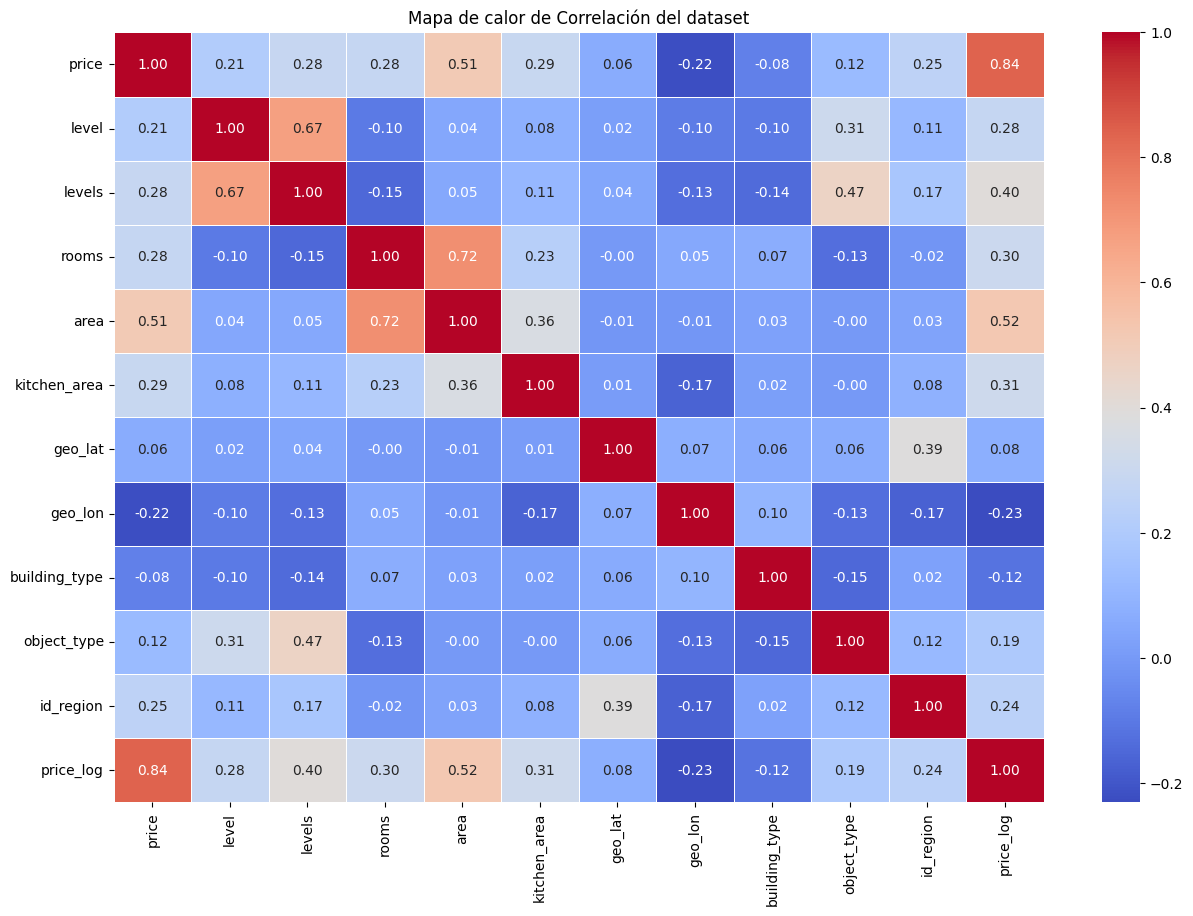

In [10]:
# Matriz de correlación para el análisis final
matriz_corr(data_sample, 15, 10)

# 1. Dividimos el dataset en variables predictoras y objetivo
features = data_sample.columns.drop(['price', 'price_log'])
X = data_sample[features]
Y = data_sample['price_log']

# 2. Dividimos en conjuntos de prueba y de entrenamiento
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=87)

# 3. Escalamiento
s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

# 4. Conversión a tensores de PyTorch
Y_train_np = Y_train.to_numpy()
Y_test_np = Y_test.to_numpy()
X_Train = torch.from_numpy(X_train.astype(np.float32))
X_Test = torch.from_numpy(X_test.astype(np.float32))
Y_Train = torch.from_numpy(Y_train_np.astype(np.float32)).view(-1,1)
Y_Test = torch.from_numpy(Y_test_np.astype(np.float32)).view(-1,1)

## 6. Modelado, Entrenamiento y Evaluación

Se define y entrena la Red Neuronal Densa.

-   **Arquitectura:** Una capa de entrada, una capa oculta con 5 neuronas (activación ReLU) y una capa de salida.
-   **Función de Pérdida:** `MSELoss` (Error Cuadrático Medio), estándar para problemas de regresión.
-   **Optimizador:** `Adam`.
-   **Hiperparámetros:** `learning_rate = 1e-3`, `max_iter = 5000`.

In [12]:
# --- Configuración y Entrenamiento del Modelo ---

# Definimos las dimensiones de entrada y salida
n_samples, n_features = X_Train.shape
input_dim = n_features
output_dim = 1
model = DNN(n = [input_dim, 5, output_dim], actfun='relu')

# Hiperparámetros
learning_rate = 1e-3
max_iter = 5000
divisor = 500

# Optimizador y Función de Pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Proceso de optimización
print("----------- Inicio del Entrenamiento -----------")
# Nota: La función de entrenamiento aquí se aplica sobre el precio logarítmico.
loss_train, loss_test = train_model(model, optimizer, criterion, X_Train, Y_Train, X_Test, Y_Test, max_iter, divisor)

----------- Inicio del Entrenamiento -----------
Iteracion 500/5000, Train loss = 131.1841
Iteracion 1000/5000, Train loss = 45.9549
Iteracion 1500/5000, Train loss = 18.5963
Iteracion 2000/5000, Train loss = 10.3964
Iteracion 2500/5000, Train loss = 5.3034
Iteracion 3000/5000, Train loss = 2.4302
Iteracion 3500/5000, Train loss = 1.1134
Iteracion 4000/5000, Train loss = 0.5306
Iteracion 4500/5000, Train loss = 0.3179
Iteracion 5000/5000, Train loss = 0.2620


## 7. Resultados y Conclusión

Una vez entrenado el modelo, se visualizan los resultados.

-   La **curva de aprendizaje** muestra una clara disminución del error, indicando que el modelo aprendió de los datos.
-   El **gráfico de dispersión** compara los precios reales con los precios predichos por el modelo (después de revertir la transformación logarítmica). La tendencia se acerca a la línea de "predicción perfecta", lo que confirma que el modelo ha capturado patrones significativos en los datos.

Aunque hay espacio para mejorar (por ejemplo, con arquitecturas más complejas o más datos), este proyecto establece una base sólida y demuestra un flujo de trabajo completo para un problema de regresión complejo.


----------- Curva de Aprendizaje -----------


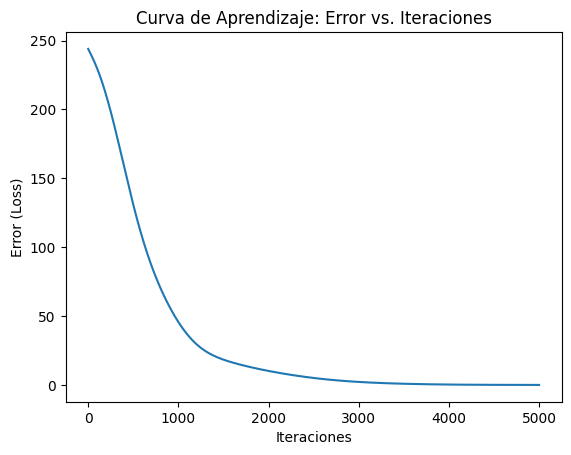

Test error final (MSE en escala logarítmica): 0.2609

----------- Gráfico de Rendimiento Final -----------


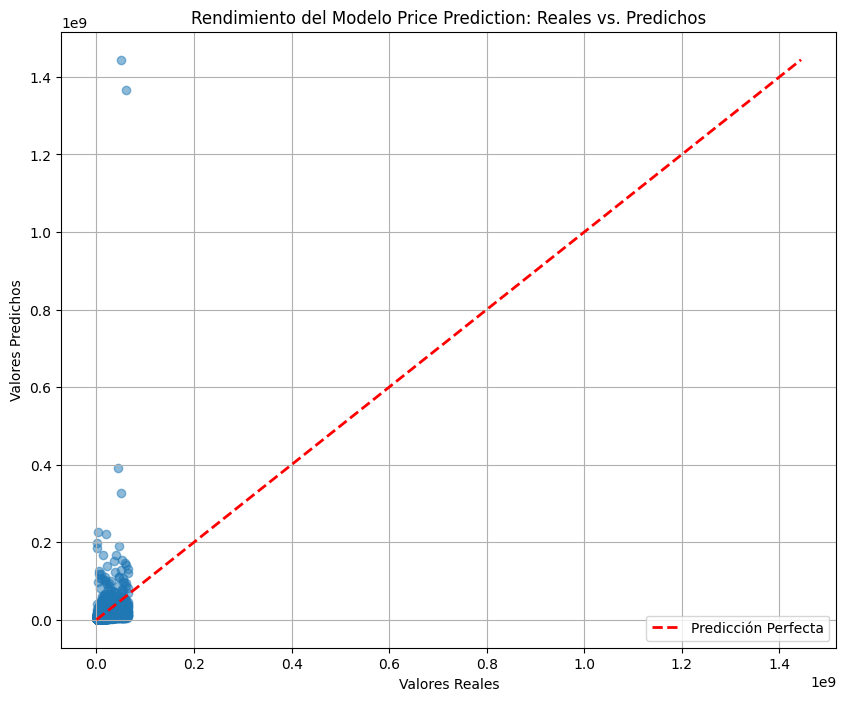

In [13]:
print("\n----------- Curva de Aprendizaje -----------")
err_vs_iter(loss_train)
print(f'Test error final (MSE en escala logarítmica): {loss_test:.4f}')

# --- Visualización de Resultados en la Escala de Precio Original ---

print("\n----------- Gráfico de Rendimiento Final -----------")
# Observamos cómo predice el modelo después de entrenar
with torch.no_grad():
    model.eval()
    # Predecir en la escala logarítmica
    y_hat_log = model(X_Test)
    # Revertir la transformación para comparar con los precios reales
    y_hat = np.expm1(y_hat_log.numpy())

# Revertir también los valores reales de prueba para la gráfica
Y_Test_no_log = np.expm1(Y_Test.numpy())

# Imprimimos la gráfica final
graf_resultados(Y_Test_no_log, y_hat, "Price Prediction")